# A Simple VAE!
*Sean Steinle, Kiya Aminfar*

This notebook represents our first attempt to train a variational auto-encoder to generate music.

## Table of Contents
1. [Exploring the Music Modality](#Exploring-the-Music-Modality)
2. [Data Processing at Scale](#Data-Processing-at-Scale)
3. [Training a Simple VAE](#Training-a-Simple-VAE)
4. [Model Analysis](#Model-Analysis)

In [1]:
import librosa, os #audio processing and file system parsing
import librosa.display
import numpy as np #math library
import tensorflow as tf #for model building
from tensorflow.keras import layers, Model
import matplotlib.pyplot as plt # for visualization
import pandas as pd #for data analysis / prep
import IPython.display as ipd #for sound output

2025-03-14 12:35:32.819938: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-14 12:35:32.821903: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-14 12:35:32.829837: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-14 12:35:32.848750: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741970132.878461    8811 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741970132.88

## Exploring the Music Modality

In this section we'll look at a single song, then load it using a standard tool of audio processing--mel spectrograms. Finally we'll explore how to normalize and shape the data.

In [2]:
popdir = "../data/genres_original/pop/"
pop_songs = os.listdir(popdir)

In [3]:
audio, sr = librosa.load(popdir+pop_songs[0], sr=None)  # sr=None keeps the original sample rate

In [4]:
print(f"This song is an array of {len(audio)} floats. The first few look like: {audio[:10]}") #it's important to assert each song is the same length during training!

This song is an array of 661504 floats. The first few look like: [0.7692261  0.2246399  0.69036865 0.7468872  0.67388916 0.42617798
 0.67840576 0.39611816 0.4371338  0.61779785]


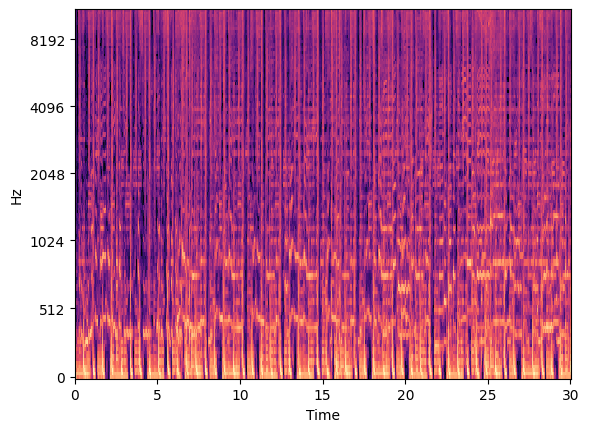

In [5]:
mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128, fmax=8000) #create spectrogram
log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max) #logscale
librosa.display.specshow(log_mel_spectrogram, x_axis='time', y_axis='mel', sr=sr) #show

In [6]:
print(f"Unnormalized values: {log_mel_spectrogram[0][:10]}")
log_mel_spectrogram -= np.mean(log_mel_spectrogram)
log_mel_spectrogram /= np.std(log_mel_spectrogram) #normalizing the floats which compromise the song
print(f"Normalized values: {log_mel_spectrogram[0][:10]}")

print(f"Initial shape: {log_mel_spectrogram.shape}")
desired_shape = (128, 128)  # pad or truncate to the shape we expect
log_mel_spectrogram = log_mel_spectrogram[:, :128] #TODO I am not sure this is a good idea!
print(f"Post-padding shape: {log_mel_spectrogram.shape}")

Unnormalized values: [-15.470793 -13.452448 -12.108845 -13.35198  -15.564962 -18.479568
 -23.243235 -23.805948 -23.893469 -23.370745]
Normalized values: [2.2659338 2.4298594 2.538984  2.4380193 2.2582853 2.021567  1.6346722
 1.5889697 1.5818615 1.624316 ]
Initial shape: (128, 1293)
Post-padding shape: (128, 128)


## Data Processing at Scale

In this section we'll take what we learned in the last section and create functions to perform processing for our entire dataset.

In [7]:
# Parameters
SAMPLE_RATE = 22050  # Standard sample rate for music processing
N_MELS = 128         # Number of Mel filterbanks
HOP_LENGTH = 512     # Hop length for STFT
N_FFT = 2048         # FFT window size
DURATION = 5         # Duration of each audio clip in seconds
BATCH_SIZE = 32

# Function to load an audio file and convert it to a Mel spectrogram
def load_audio_to_mel(file_path):
    y, sr = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)  # Convert to log scale (dB)
    
    # Normalize to [0,1]
    mel_spec_norm = (mel_spec_db - mel_spec_db.min()) / (mel_spec_db.max() - mel_spec_db.min())
    #TODO - add padding?
    
    return mel_spec_norm

# Function to display a Mel spectrogram
def plot_mel_spectrogram(mel_spec):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_spec, sr=SAMPLE_RATE, hop_length=HOP_LENGTH, cmap='magma')
    plt.colorbar(label="Amplitude (dB)")
    plt.xlabel("Time")
    plt.ylabel("Mel Frequency")
    plt.title("Mel Spectrogram")
    plt.show()

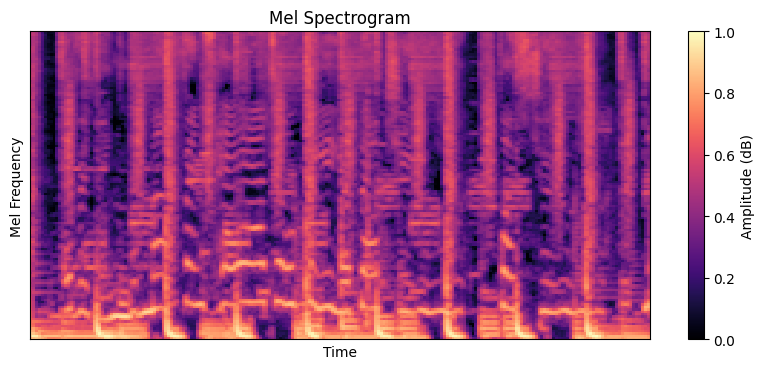

In [8]:
# Test with an example file
mel_spec = load_audio_to_mel(popdir+pop_songs[0])
plot_mel_spectrogram(mel_spec)

In [9]:
def load_music_df(music_dir: str):
    """This function loads a directory of songs and creates a simple dataframe with (genre,song,numpy) rows. We expect music_dir to be a 2-level directory with genre directories on the first level and .wav songs on the seocnd level."""
    music_dir = "../data/genres_original/"
    music_dicts,bad_paths = [],[]
    genres = os.listdir(music_dir)
    for genre in genres:
        try:
            for song in os.listdir(music_dir+genre):
                song_path = music_dir+genre+'/'+song
                try:
                    music_dicts.append({'genre': genre, 'song': song, 'numpy_representation': load_audio_to_mel(song_path)})
                except Exception as e:
                    print(f"couldn't load: {song_path}, got: {e}")
                    bad_paths.append([song_path,e])
        except Exception as e:
            print(f"couldn't process the {genre} directory, got: {e}")
    return pd.DataFrame(music_dicts)

In [10]:
music_df = load_music_df("../data/genres_original/")
music_df

/tmp/ipykernel_8811/2620629502.py:11: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)
/home/seansteinle/.pyenv/versions/3.10.16/envs/cs757-p1/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


couldn't load: ../data/genres_original/jazz/jazz.00054.wav, got: 


,genre,song,numpy_representation
0,hiphop,hiphop.00023.wav,"[[0.6470897, 0.74628973, 0.85233957, 0.8991294..."
1,hiphop,hiphop.00005.wav,"[[0.7381693, 0.76228845, 0.7563869, 0.7746822,..."
2,hiphop,hiphop.00038.wav,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,hiphop,hiphop.00089.wav,"[[0.8277605, 0.86236286, 0.8714711, 0.870451, ..."
4,hiphop,hiphop.00011.wav,"[[0.646747, 0.61034644, 0.60831213, 0.65671754..."
...,...,...,...
994,reggae,reggae.00077.wav,"[[0.7917141, 0.85415596, 0.8514075, 0.7689682,..."
995,reggae,reggae.00088.wav,"[[0.56345046, 0.550356, 0.47493, 0.4327871, 0...."
996,reggae,reggae.00061.wav,"[[0.6031495, 0.5246515, 0.4823317, 0.47101286,..."
997,reggae,reggae.00009.wav,"[[0.6001226, 0.5241723, 0.45086735, 0.45777068..."


In [11]:
music_df = load_music_df("../data/genres_original/")
music_df.value_counts('genre') #perfectly split dataset except for jazz which has a corrupted song :(

/tmp/ipykernel_8811/2620629502.py:11: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)
/home/seansteinle/.pyenv/versions/3.10.16/envs/cs757-p1/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


couldn't load: ../data/genres_original/jazz/jazz.00054.wav, got: 


genre
blues        100
classical    100
country      100
disco        100
hiphop       100
metal        100
reggae       100
pop          100
rock         100
jazz          99
Name: count, dtype: int64

In [12]:
#looks like every song is the same shape, good news!
set(music_df['numpy_representation'].apply(lambda x: x.shape).tolist())

{(128, 216)}

In [13]:
def create_tf_dataset(music_df):
    """This convenience function converts our music_df's numpy column to a tensorflow-ready dataset."""
    numpy_representations = np.array(music_df["numpy_representation"].tolist(), dtype=np.float32)  
    numpy_representations = np.expand_dims(numpy_representations, -1)  # Add channel dimension
    songs_dataset = tf.data.Dataset.from_tensor_slices(numpy_representations)
    songs_dataset = songs_dataset.shuffle(len(numpy_representations)).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
    return songs_dataset

In [14]:
songs_dataset = create_tf_dataset(music_df)

2025-03-14 12:36:35.293242: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


## Training a Simple VAE

This section is our first stab at a VAE with just a few layers in the encoder and decoder.

In [15]:
# Parameters
LATENT_DIM = 64  # Latent space dimension
INPUT_SHAPE = (128, 216, 1)  # (Mel bins, Time steps, Channels)

class ResizeLayer(layers.Layer):
    """"Does a hard resize before decoder output. See the differences between a reshape and a resize here: https://numpy.org/doc/stable/reference/generated/numpy.resize.html."""
    def __init__(self, target_size):
        super(ResizeLayer, self).__init__()
        self.target_size = target_size

    def call(self, inputs):
        return tf.image.resize(inputs, self.target_size)

# Reparameterization Trick
def sampling(args):
    """Reparameterization trick: z = mu + exp(log_var / 2) * epsilon"""
    mu, log_var = args
    epsilon = tf.keras.backend.random_normal(shape=tf.shape(mu))
    return mu + tf.exp(log_var * 0.5) * epsilon

# VAE Model Class
class VAE(Model):
    def __init__(self, input_shape=INPUT_SHAPE, latent_dim=LATENT_DIM):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = self.build_encoder(input_shape, latent_dim)

        # Decoder
        self.decoder = self.build_decoder(latent_dim, input_shape)

    def build_encoder(self, input_shape, latent_dim):
        """Builds the VAE Encoder."""
        inputs = layers.Input(shape=input_shape)

        x = layers.Conv2D(32, (3, 3), strides=(2, 2), padding="same", activation="relu")(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same", activation="relu")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same", activation="relu")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Flatten()(x)

        mu = layers.Dense(latent_dim, name="latent_mu")(x)
        log_var = layers.Dense(latent_dim, name="latent_log_var")(x)
        z = layers.Lambda(sampling, name="latent_sample")([mu, log_var])

        return Model(inputs, [mu, log_var, z], name="Encoder")

    def build_decoder(self, latent_dim, output_shape):
        decoder_inputs = layers.Input(shape=(latent_dim,))
    
        # Adjust output size based on input time_steps (216)
        x = layers.Dense(16 * 27 * 128, activation="relu")(decoder_inputs)  # 16x27 ensures 216 in time dim
        x = layers.Reshape((16, 27, 128))(x)  # Ensure correct shape
    
        x = layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding="same", activation="relu")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding="same", activation="relu")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding="same", activation="relu")(x)
        x = layers.BatchNormalization()(x)
    
        # Ensure output shape is (128, 216, 1)
        outputs = layers.Conv2DTranspose(1, (3, 3), padding="same", activation="sigmoid")(x)
        outputs = ResizeLayer((128, 216))(outputs)  # Resize to match the input shape
    
        return Model(decoder_inputs, outputs, name="Decoder")

    def call(self, inputs):
        """Forward pass through the VAE."""
        mu, log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        return reconstructed

    def compute_loss(self, inputs):
        """Computes the VAE loss function."""
        mu, log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)

        # Reconstruction loss
        recon_loss = tf.reduce_mean(tf.keras.losses.mse(inputs, reconstructed))

        # KL Divergence loss
        kl_loss = -0.5 * tf.reduce_mean(1 + log_var - tf.square(mu) - tf.exp(log_var))

        return recon_loss + kl_loss

    def train_step(self, data):
        """Custom training step."""
        with tf.GradientTape() as tape:
            loss = self.compute_loss(data)
        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        return {"loss": loss}

In [16]:
# Create and compile the VAE
vae = VAE()
vae.compile(optimizer=tf.keras.optimizers.Adam())

# Training
# Assume `songs_dataset` is prepared
n_epochs = 100
vae.fit(songs_dataset, epochs=n_epochs)

Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 28s 734ms/step - loss: 0.0379
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 25s 776ms/step - loss: 0.0263
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 24s 738ms/step - loss: 0.0234
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 24s 739ms/step - loss: 0.0226
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 26s 809ms/step - loss: 0.0228
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 24s 762ms/step - loss: 0.0223
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 28s 859ms/step - loss: 0.0221
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 27s 837ms/step - loss: 0.0220
Epoch 9/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 24s 756ms/step - loss: 0.0222
Epoch 10/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 27s 834ms/step - loss: 0.0219
Epoch 11/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 26s 803ms/step - loss: 0.0222
Epoch 12/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 30s 936ms/step - loss: 0.0216
Epoch 13/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 27s 837ms/step - loss: 0.0224
Epoch 14/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 27s 848ms/step - loss: 0.0219
Epoch 15/100
32/32 ━━━━━━━━━━

## Model Analysis

Here we examine qualitative aspects of our model performance, including generated sample spectrograms and raw audio as well as the latent space.

In [17]:
def generate_samples(model, num_samples=10):
    """Convenience function for generating num_samples from model."""
    random_latent_vectors = tf.random.normal(shape=(num_samples, LATENT_DIM)) # Sample random latent vectors from the prior (e.g., normal distribution)
    generated_samples = model.decoder(random_latent_vectors) # Use the decoder to generate samples from the random latent vectors
    generated_samples = [s.numpy().squeeze() for s in generated_samples] #convert to numpy, reshape
    return generated_samples

# Generate new samples
generated_samples = generate_samples(vae, num_samples=5)
generated_samples

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


[array([[0.57869494, 0.5714488 , 0.57071894, ..., 0.57964766, 0.5824936 ,
         0.55805975],
        [0.6538479 , 0.671717  , 0.68075967, ..., 0.6955039 , 0.6985231 ,
         0.64912426],
        [0.67313284, 0.69774586, 0.71798754, ..., 0.73731786, 0.73727137,
         0.69341105],
        ...,
        [0.16763477, 0.17086181, 0.15467133, ..., 0.13559975, 0.13561265,
         0.20566368],
        [0.15301867, 0.1637681 , 0.14681062, ..., 0.12526605, 0.12862916,
         0.18272288],
        [0.16022839, 0.15266068, 0.14590578, ..., 0.12196982, 0.12166339,
         0.19915447]], dtype=float32),
 array([[0.57913625, 0.57219774, 0.56926763, ..., 0.5786279 , 0.5816313 ,
         0.55697626],
        [0.6536971 , 0.6724617 , 0.6787553 , ..., 0.69423866, 0.6969537 ,
         0.64792514],
        [0.67293555, 0.6977843 , 0.7159279 , ..., 0.7344628 , 0.73513067,
         0.6911257 ],
        ...,
        [0.1757985 , 0.18194582, 0.16186692, ..., 0.15162583, 0.15402494,
         0.22738673

*Audio Inspection*

In [18]:
def mel_to_audio(mel_spec, sr=22050, n_fft=2048, hop_length=512, n_mels=128, power=1.0):
    """
    Convert a Mel spectrogram back to audio using the Griffin-Lim algorithm.
    Args:
        mel_spec: Mel spectrogram (shape: [n_mels, time_steps])
        sr: Sample rate for the audio
        n_fft: FFT size for Griffin-Lim
        hop_length: Hop length for Griffin-Lim
        n_mels: Number of Mel bins in the spectrogram
        power: Exponent for the spectrogram
    Returns:
        Audio signal as a numpy array
    """
    # Invert Mel to linear scale
    mel_inverted = librosa.feature.inverse.mel_to_audio(mel_spec ** power, sr=sr, n_fft=n_fft, hop_length=hop_length)
    return mel_inverted

In [19]:
popdir = "../data/genres_original/pop/"
pop_songs = os.listdir(popdir)
original_gt_audio, sr = librosa.load(popdir+pop_songs[0], sr=None)  # sr=None keeps the original sample rate

print("Original Ground-Truth Audio:")
ipd.display(ipd.Audio(original_gt_audio, rate=sr))

FileNotFoundError: [Errno 2] No such file or directory: '../data/genres_original/pop/'

In [ ]:
mel_spec = librosa.feature.melspectrogram(y=original_gt_audio, sr=sr, n_mels=128, fmax=8000)
transformed_gt_audio = mel_to_audio(mel_spec, sr=sr)

print("Reconstructed Audio from Mel Spectrogram:")
ipd.display(ipd.Audio(transformed_gt_audio, rate=sr))

In [ ]:
mel_audio = mel_to_audio(generated_samples[0])
ipd.Audio(mel_audio, rate=22050) #generated sample

Above we have three audio samples:
1. *original_gt_audio* - This is unprocessed audio from our dataset.
2. *transformed_gt_audio* - This is audio from our dataset which has been transformed into a spectrogram and back.
3. *generated_samples[0]* - This is the generated spectrogram which our model created, transformed from a spectrogram into audio.

*Visual Inspection of Spectrograms*

In [ ]:
plot_mel_spectrogram(mel_spec) #real sample
plot_mel_spectrogram(generated_samples[0]) #generated sample

It's clear from this spectrogram that we are not producing high-quality audio. We're missing the fine-grained details in real audio.

*Visual Inspection of Latent Space*

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

# Function to get the latent vectors (z_mean) from the encoder
def get_latent_vectors(model, dataset):
    # Get the encoder output (z_mean) from the dataset
    latent_vectors = []
    for data in dataset:
        z_mean, _, _ = model.encoder(data)  # Passing data through the encoder to get z_mean
        latent_vectors.append(z_mean.numpy())  # Convert to numpy array for further processing
    return np.vstack(latent_vectors)

# Example usage (get latent vectors for the entire dataset)
latent_vectors = get_latent_vectors(vae, songs_dataset)

print(f"Latent vectors shape: {latent_vectors.shape}")

In [ ]:
pca = PCA(n_components=2)
latent_2d = pca.fit_transform(latent_vectors)

# Assume you have genre labels (from music_df)
genres = music_df['genre'].values  # Example: ['rock', 'pop', 'jazz', ...]

# Create a color map for the genres
unique_genres = np.unique(genres)
color_map = {genre: plt.cm.get_cmap("tab10")(i) for i, genre in enumerate(unique_genres)}

# Color the latent space points by genre
plt.figure(figsize=(8, 6))
for genre in unique_genres:
    genre_indices = np.where(genres == genre)[0]
    plt.scatter(latent_2d[genre_indices, 0], latent_2d[genre_indices, 1], label=genre, alpha=0.5)

plt.title('Latent Space Visualization (PCA with Genre Colors)')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.legend(loc='best')
plt.show()


I would say this looks multivariate normal-ish! Interesting that the genres aren't clustered in any meaningful way. I hypothesize a better VAE would have a more semantically salient latent space.

In [ ]:
vae.encoder.save('../models/myencoder.keras')